In [ ]:
# @title Setup CUDA Libraries for JAX
# This cell must be run BEFORE importing JAX

import os
import sys
import ctypes
import glob

# Get the path to NVIDIA CUDA libraries
cuda_base_path = os.path.join(sys.prefix, 'lib', f'python{sys.version_info.major}.{sys.version_info.minor}', 'site-packages', 'nvidia')

if os.path.exists(cuda_base_path):
    # Collect all library directories
    lib_dirs = []
    for item in os.listdir(cuda_base_path):
        lib_dir = os.path.join(cuda_base_path, item, 'lib')
        if os.path.isdir(lib_dir):
            lib_dirs.append(lib_dir)
    
    # Set LD_LIBRARY_PATH (for any subprocesses)
    if lib_dirs:
        os.environ['LD_LIBRARY_PATH'] = ':'.join(lib_dirs) + ':' + os.environ.get('LD_LIBRARY_PATH', '')
        
        # Preload CUDA libraries in dependency order (dependencies first!)
        # Order matters: load base libraries before those that depend on them
        critical_libs = [
            'libnvJitLink.so.12',      # Base library
            'libcublasLt.so.12',       # Base library
            'libcublas.so.12',         # Depends on cublasLt
            'libcusparse.so.12',       # Depends on nvJitLink
            'libcusolver.so.11',       # Depends on cublas
            'libcudnn.so.9',           # Neural network library
            'libcufft.so.11',          # FFT library
        ]
        
        loaded_count = 0
        for lib_name in critical_libs:
            for lib_dir in lib_dirs:
                lib_path = os.path.join(lib_dir, lib_name)
                if os.path.exists(lib_path):
                    try:
                        # Force load the library into the current process
                        ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
                        print(f"✓ Loaded {lib_name}")
                        loaded_count += 1
                    except Exception as e:
                        print(f"✗ Failed to load {lib_name}: {e}")
                    break
        
        print(f"\n✓ Successfully loaded {loaded_count}/{len(critical_libs)} CUDA libraries")
        print("✓ CUDA configured for JAX")
else:
    print("Warning: CUDA libraries not found")


✗ Failed to load libcusparse.so.12: /home/skr/miniconda3/envs/disco/lib/python3.11/site-packages/nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkGetErrorLogSize_12_9, version libnvJitLink.so.12
✗ Failed to load libcublas.so.12: /home/skr/miniconda3/envs/disco/lib/python3.11/site-packages/nvidia/cublas/lib/libcublas.so.12: undefined symbol: cublasLtGetEnvironmentMode, version libcublasLt.so.12
✓ Loaded libcublasLt.so.12
✗ Failed to load libcusolver.so.11: /home/skr/miniconda3/envs/disco/lib/python3.11/site-packages/nvidia/cusolver/lib/libcusolver.so.11: undefined symbol: cublasSetEnvironmentMode, version libcublas.so.12

✓ CUDA libraries configured for JAX


# Meta-training / finetuning update rules

This colab demonstrates how to finetune the `Disco103` update rule on a jittable version of `Catch` using a population of agents.

The repository also contains a CPU version of `Catch`; feel free to explore and repurpose this code for your needs.

In [2]:
# @title Install the package.

# !pip install git+https://github.com/google-deepmind/disco_rl.git

from typing import Any

import chex
import distrax
import haiku as hk
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from ml_collections import config_dict
import numpy as np
import optax
import pandas as pd
import rlax
import seaborn as sns
import tqdm

# Types & utils
from disco_rl import types
from disco_rl import utils

# Environments
from disco_rl.environments import base as base_env
from disco_rl.environments import jittable_envs

# Learning
from disco_rl import agent as agent_lib
from disco_rl.value_fns import value_fn

axis_name = 'i'  # for parallelisation

# Verify GPU is available
print(f"JAX devices: {jax.devices()}")
print(f"Default backend: {jax.default_backend()}")

JAX devices: [CudaDevice(id=0)]
Default backend: gpu


In [ ]:
# @title Download and unpack `Disco103` weights.

def unflatten_params(flat_params: chex.ArrayTree) -> chex.ArrayTree:
  params = {}
  for key_wb in flat_params:
    key = '/'.join(key_wb.split('/')[:-1])
    params[key] = {
        'b': flat_params[f'{key}/b'],
        'w': flat_params[f'{key}/w'],
    }
  return params


disco_103_fname = 'disco_103.npz'
disco_103_url = f"https://raw.githubusercontent.com/google-deepmind/disco_rl/main/disco_rl/update_rules/weights/{disco_103_fname}"
# !wget $disco_103_url

with open(f'/home/skr/Downloads/disco_rl/colabs/disco_103.npz', 'rb') as file:
  disco_103_params = unflatten_params(np.load(file))

print(f'Loaded {len(disco_103_params) * 2} parameter tensors for Disco103.')

--2025-10-30 08:13:23--  https://raw.githubusercontent.com/google-deepmind/disco_rl/main/disco_rl/update_rules/weights/disco_103.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 

/home/skr/miniconda3/envs/disco/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


200 OK
Length: 2803507 (2.7M) [application/octet-stream]
Saving to: ‘disco_103.npz’

disco_103.npz       100%[===================>]   2.67M  10.5MB/s    in 0.3s    

2025-10-30 08:13:23 (10.5 MB/s) - ‘disco_103.npz’ saved [2803507/2803507]

Loaded 42 parameter tensors for Disco103.


In [4]:
# @title Configure a simple MLP agent.


def get_env(batch_size: int) -> base_env.Environment:
  return jittable_envs.CatchJittableEnvironment(
      batch_size=batch_size,
      env_settings=config_dict.ConfigDict(dict(rows=5, columns=5)),
  )


# Create a dummy environment.
env = get_env(batch_size=1)

# Create settings for an agent.
agent_settings = agent_lib.get_settings_disco()
agent_settings.net_settings.name = 'mlp'
agent_settings.net_settings.net_args = dict(
    dense=(512, 512),
    model_arch_name='lstm',
    head_w_init_std=1e-2,
    model_kwargs=dict(
        head_mlp_hiddens=(256,),
        lstm_size=256,
    ),
)
agent_settings.learning_rate = 5e-4

# Create the agent.
agent = agent_lib.Agent(
    agent_settings=agent_settings,
    single_observation_spec=env.single_observation_spec(),
    single_action_spec=env.single_action_spec(),
    batch_axis_name=axis_name,
)

# Ensure that the agent's update rule's parameters have the same specs.
random_update_rule_params, _ = agent.update_rule.init_params(
    jax.random.PRNGKey(1)
)
if agent_settings.update_rule_name == 'disco':
  chex.assert_trees_all_equal_shapes_and_dtypes(
      random_update_rule_params, disco_103_params
  )
  print('Update rule parameters have the same specs.')
else:
  print('Not using a discovered rule, skipping check.')

Update rule parameters have the same specs.


In [5]:
# @title Helper functions for interacting with environments.

def unroll_jittable_actor(
    params,
    actor_state,
    ts,
    env_state,
    rng,
    env,
    rollout_len,
    actor_step_fn,
):

  def _single_step(carry, step_rng):
    env_state, ts, actor_state = carry
    actor_timestep, actor_state = actor_step_fn(
        params, step_rng, ts, actor_state
    )
    env_state, ts = env.step(env_state, actor_timestep.actions)
    return (env_state, ts, actor_state), actor_timestep

  (env_state, ts, actor_state), actor_rollout = jax.lax.scan(
      _single_step,
      (env_state, ts, actor_state),
      jax.random.split(rng, rollout_len),
  )

  actor_rollout = types.ActorRollout.from_timestep(actor_rollout)
  return actor_rollout, actor_state, ts, env_state

In [6]:
# @title Meta training agent


@chex.dataclass
class MetaTrainState:
  learner_state: agent_lib.LearnerState
  actor_state: types.HaikuState
  value_state: types.ValueState
  env_state: Any
  env_timestep: types.EnvironmentTimestep


class MetaTrainAgent:
  """Meta training agent bundles together all meta training-related funct-ty."""

  agent: agent_lib.Agent
  value_fn: value_fn.ValueFunction
  env: base_env.Environment

  def __init__(
      self,
      batch_size_per_device: int,
      agent_settings: config_dict.ConfigDict,
      value_fn_config: types.ValueFnConfig,
      axis_name: str | None = axis_name,
  ):
    self.env = get_env(batch_size_per_device)
    self.agent = agent_lib.Agent(
        agent_settings=agent_settings,
        single_observation_spec=self.env.single_observation_spec(),
        single_action_spec=self.env.single_action_spec(),
        batch_axis_name=axis_name,
    )
    self.value_fn = value_fn.ValueFunction(value_fn_config, axis_name=axis_name)
    self._unroll_jittable_actor = jax.jit(
        unroll_jittable_actor,
        static_argnames=('env', 'rollout_len', 'actor_step_fn'),
    )

  @property
  def learner_step(self):
    return self.agent.learner_step

  @property
  def actor_step(self):
    return self.agent.actor_step

  @property
  def unroll_net(self):
    return self.agent.unroll_net

  def init_state(self, rng_key: chex.PRNGKey) -> MetaTrainState:
    """Initialize the meta train state."""
    dummy_obs = utils.zeros_like_spec(
        self.env.single_observation_spec(),
        prepend_shape=(batch_size_per_device,),
    )
    rng_keys = jax.random.split(rng_key, 3)
    env_state, env_timestep = self.env.reset(rng_key)
    return MetaTrainState(
        learner_state=self.agent.initial_learner_state(rng_keys[0]),
        actor_state=self.agent.initial_actor_state(rng_keys[1]),
        value_state=self.value_fn.initial_state(rng_keys[2], dummy_obs),
        env_state=env_state,
        env_timestep=env_timestep,
    )

  def unroll_actor(
      self, state: MetaTrainState, rng: chex.PRNGKey, rollout_len: int
  ) -> tuple[MetaTrainState, types.ActorRollout]:
    """Unrolls the actor for the given number of steps and updates the state."""
    rollout, new_actor_state, new_env_timestep, new_env_state = (
        self._unroll_jittable_actor(
            state.learner_state.params,
            state.actor_state,
            state.env_timestep,
            state.env_state,
            rng,
            self.env,
            rollout_len,
            self.actor_step,
        )
    )
    new_state = MetaTrainState(
        learner_state=state.learner_state,
        actor_state=new_actor_state,
        value_state=state.value_state,
        env_state=new_env_state,
        env_timestep=new_env_timestep,
    )
    return new_state, rollout


In [7]:
# @title Calculate meta gradients for a single agent.


def calculate_meta_gradient(
    update_rule_params: types.MetaParams,
    agent_state: MetaTrainState,
    train_rollouts: types.ActorRollout,
    valid_rollout: types.ActorRollout,
    rng: chex.PRNGKey,
    agent: MetaTrainAgent,
    axis_name: str | None = axis_name,
):
  """Calculates meta gradients for a single agent."""

  unroll_len = train_rollouts.rewards.shape[0]

  def _inner_step(carry, inputs):
    """Updates agent's and value fn's params using the current update rule."""
    update_rule_params, learner_state, actor_state, value_state = carry
    actor_rollout, learner_rng = inputs

    # Update agent's parameters.
    new_learner_state, new_actor_state, metrics = agent.learner_step(
        rng=learner_rng,
        rollout=actor_rollout,
        learner_state=learner_state,
        agent_net_state=actor_state,
        update_rule_params=update_rule_params,
        is_meta_training=True,
    )

    # Update value function.
    agent_out, _ = agent.unroll_net(
        learner_state.params, actor_state, actor_rollout
    )
    new_value_state, _, _ = agent.value_fn.update(
        value_state, actor_rollout, agent_out['logits']
    )

    return (
        update_rule_params,
        new_learner_state,
        new_actor_state,
        new_value_state,
    ), metrics

  def _outer_loss(
      update_rule_params: types.MetaParams,
      agent_state: MetaTrainState,
      train_rollouts: types.ActorRollout,
      valid_rollout: types.ActorRollout,
      rng: chex.PRNGKey,
  ):
    """Calculates (meta) loss for the update rule."""
    train_rng, valid_rng = jax.random.split(rng, 2)

    # Perform N inner steps (i.e. agent's params' updates).
    learner_rngs = jax.random.split(train_rng, unroll_len)
    (_, new_learner_state, new_actor_state, new_value_state), train_metrics = (
        jax.lax.scan(
            _inner_step,
            (
                update_rule_params,
                agent_state.learner_state,
                agent_state.actor_state,
                agent_state.value_state,
            ),
            (train_rollouts, learner_rngs),
        )
    )
    train_meta_out = train_metrics.pop('meta_out')

    # Run inference on the validation rollout.
    agent_rollout_on_valid, _ = hk.BatchApply(
        lambda ts: agent.actor_step(
            actor_params=new_learner_state.params,
            rng=valid_rng,
            timestep=ts,
            actor_state=valid_rollout.first_state(time_axis=0),
        )
    )(valid_rollout.to_env_timestep())

    # Calculate value_fn on the validation rollout.
    value_out, _, _, _ = agent.value_fn.get_value_outs(
        new_value_state, valid_rollout, agent_rollout_on_valid['logits']
    )
    actions_on_valid = valid_rollout.actions[:-1]
    logits_on_valid = agent_rollout_on_valid['logits'][:-1]
    adv_t = jax.lax.stop_gradient(value_out.normalized_adv)

    # Calculate meta loss' components.
    # Policy gradient loss.
    pg_loss_per_step = utils.differentiable_policy_gradient_loss(
        logits_on_valid, actions_on_valid, adv_t=adv_t, backprop=False
    )

    # Meta regularizers.
    reg_loss = 0
    reg_loss += -1e-2 * distrax.Softmax(logits_on_valid).entropy().mean() # entr

    # Validation regularisers.
    agent_out_on_valid = agent_rollout_on_valid.agent_outs
    z_a = utils.batch_lookup(agent_out_on_valid['z'][:-1], actions_on_valid)
    y_entropy_loss = -jnp.mean(
        distrax.Softmax(agent_out_on_valid['y']).entropy()
    )
    z_entropy_loss = -jnp.mean(distrax.Softmax(z_a).entropy())
    reg_loss += 1e-3 * (y_entropy_loss + z_entropy_loss)

    # Train regularisers.
    dp, dy, dz = train_meta_out['pi'], train_meta_out['y'], train_meta_out['z']
    chex.assert_equal_shape_prefix([dp, dy, dz], 3)  # [N, T, B, ...]
    reg_loss += 1e-3 * jnp.mean(jnp.square(jnp.mean(dy, axis=(1, 2, 3))))
    reg_loss += 1e-3 * jnp.mean(jnp.square(jnp.mean(dz, axis=(1, 2, 3))))
    reg_loss += 1e-3 * jnp.mean(jnp.square(jnp.mean(dp, axis=(1, 2, 3))))
    logits = train_meta_out['target_out']['logits'][:, :-1]
    chex.assert_equal_shape([logits, dp])  # [N, T, B, A]
    target_kl_loss = rlax.categorical_kl_divergence(
        jax.lax.stop_gradient(logits), dp
    )
    reg_loss += 1e-2 * jnp.mean(target_kl_loss)

    # Meta loss.
    meta_loss = pg_loss_per_step.mean() + reg_loss

    # Update logs and states.
    meta_log = dict(
        adv=value_out.adv.mean(),
        normalized_adv=value_out.normalized_adv.mean(),
        entropy=distrax.Softmax(logits_on_valid).entropy().mean(),
        value=value_out.value.mean(),
        val_importance_weight=jnp.mean(jnp.minimum(value_out.rho, 1.0)),
        meta_loss=meta_loss,
        pg_loss=pg_loss_per_step.mean(),
        reg_loss=reg_loss,
    )
    new_agent_state = MetaTrainState(
        learner_state=new_learner_state,
        actor_state=new_actor_state,
        value_state=new_value_state,
        env_state=agent_state.env_state,
        env_timestep=agent_state.env_timestep,
    )

    return meta_loss, (new_agent_state, train_metrics, meta_log)

  # Calculate meta gradients.
  meta_grads, outputs = jax.grad(_outer_loss, has_aux=True)(
      update_rule_params, agent_state, train_rollouts, valid_rollout, rng
  )
  new_agent_state, train_metrics, meta_log = outputs
  if axis_name is not None:
    (meta_grads, train_metrics, meta_log) = jax.lax.pmean(
        (meta_grads, train_metrics, meta_log), axis_name
    )

  return meta_grads, (new_agent_state, train_metrics, meta_log)

In [8]:
# @title Meta update step (requires calculating meta gradients for all agents).


def meta_update(
    update_rule_params: types.MetaParams,
    meta_opt_state: optax.OptState,
    agents_states: list[MetaTrainState],
    rng: chex.PRNGKey,
    axis_name: str | None = axis_name,
):
  """Calculates an update for the meta parameters."""

  # Generate `num_inner_steps` trajectories for each of `num_agents` agents.
  train_rollouts = [None] * num_agents
  valid_rollouts = [None] * num_agents
  rng_act, rng_upd = jax.random.split(rng)
  rngs_per_agent_act = jax.random.split(rng_act, num_agents)
  for agent_i in range(num_agents):
    agent, state = agents[agent_i], agents_states[agent_i]
    rollouts = [None] * num_inner_steps
    rngs_per_step = jax.random.split(
        rngs_per_agent_act[agent_i], num_inner_steps
    )
    for step_i in range(num_inner_steps):
      state, rollouts[step_i] = agent.unroll_actor(
          state, rngs_per_step[step_i], rollout_len
      )
    train_rollouts[agent_i] = utils.tree_stack(rollouts)

    # Generate 2x longer trajectories for validation.
    agents_states[agent_i], valid_rollouts[agent_i] = agent.unroll_actor(
        state, rngs_per_agent_act[agent_i], 2 * rollout_len
    )

  # Calculate meta gradients for each agent.
  meta_grads = [None] * num_agents
  rngs_per_agent_upd = jax.random.split(rng_upd, num_agents)
  metrics, meta_log = None, None
  for agent_i in range(num_agents):
    meta_grads[agent_i], (agents_states[agent_i], metrics, meta_log) = (
        calculate_meta_gradient(
            update_rule_params=update_rule_params,
            agent_state=agents_states[agent_i],
            train_rollouts=train_rollouts[agent_i],
            valid_rollout=valid_rollouts[agent_i],
            rng=rngs_per_agent_upd[agent_i],
            agent=agents[agent_i],
            axis_name=axis_name,
        )
    )

  # Log rewards and proportion positive rewards.
  rewards = [None] * num_agents
  pos_rewards = [None] * num_agents
  neg_rewards = [None] * num_agents
  for agent_i in range(num_agents):
    assert train_rollouts[agent_i] is not None
    r = train_rollouts[agent_i].rewards
    rewards[agent_i] = r.mean()

    pos_rewards[agent_i] = (r > 0).sum()
    neg_rewards[agent_i] = (r < 0).sum()

  # Average meta gradients across all agents and pass through meta optimizer.
  # Note that we had a separate meta optimiser for each agent in the original
  # work; that logic is omitted here for simplicity.
  avg_meta_gradient = jax.tree.map(
      lambda x: x.mean(axis=0), utils.tree_stack(meta_grads)
  )
  meta_update, meta_opt_state = meta_opt.update(
      avg_meta_gradient, meta_opt_state
  )
  update_rule_params = optax.apply_updates(update_rule_params, meta_update)

  meta_log['meta_grad_norm'] = optax.global_norm(avg_meta_gradient)
  meta_log['meta_up_norm'] = optax.global_norm(meta_update)
  meta_log['rewards'] = utils.tree_stack(rewards).mean()
  meta_log['pos_rewards'] = utils.tree_stack(pos_rewards).mean()
  meta_log['neg_rewards'] = utils.tree_stack(neg_rewards).mean()
  return update_rule_params, meta_opt_state, agents_states, metrics, meta_log

In [9]:
# @title Meta training config

num_steps = 800
num_agents = 2
rollout_len = 16
num_inner_steps = 2
batch_size_per_device = 32
rng_key = jax.random.PRNGKey(4)

value_fn_config = types.ValueFnConfig(
    net='mlp',
    net_args=dict(
        dense=(256, 256),
        head_w_init_std=1e-2,
        action_spec=(),
    ),
    learning_rate=1e-3,
    max_abs_update=1.0,
    discount_factor=0.99,
    td_lambda=0.96,
    outer_value_cost=1.0,
)

# Use random params for the update rule.
update_rule_params = random_update_rule_params  # can be `disco_103_params`
meta_opt = optax.adam(learning_rate=5e-4)

meta_opt_state = meta_opt.init(update_rule_params)
meta_log = {}
metrics = {}

# Create multiple agents.
agents = []
agents_states = []
rng, rng_key = jax.random.split(rng_key)
for rng_key in jax.random.split(rng_key, num_agents):
  agents.append(
      MetaTrainAgent(
          batch_size_per_device=batch_size_per_device,
          agent_settings=agent_settings,
          value_fn_config=value_fn_config,
      )
  )
  agents_states.append(agents[-1].init_state(rng_key))

# Parallelise using all available devices.
devices = jax.devices()
jitted_meta_update = jax.pmap(meta_update, axis_name=axis_name, devices=devices)

In [10]:
# @title Run meta-training (note that compilation can take time!).

# Replicate parameters for each device.
step_update_rule_params = jax.device_put_replicated(
    update_rule_params, devices
)
step_meta_opt_state = jax.device_put_replicated(meta_opt_state, devices)
step_agents_states = jax.device_put_replicated(agents_states, devices)

# Run the meta learning loop.
for meta_step in tqdm.tqdm(range(num_steps)):
  if meta_step in metrics:  # to support interrupting and continuing
    continue

  rng, step_rngs = jax.random.split(rng)
  step_rngs = jax.random.split(step_rngs, len(devices))
  (
      step_update_rule_params,
      step_meta_opt_state,
      step_agents_states,
      metrics[meta_step],
      meta_log[meta_step],
  ) = jitted_meta_update(
      update_rule_params=step_update_rule_params,
      meta_opt_state=step_meta_opt_state,
      agents_states=step_agents_states,
      rng=step_rngs,
  )
  metrics[meta_step], meta_log[meta_step] = jax.device_get(
      (metrics[meta_step], meta_log[meta_step])
  )

# Collect metrics from all devices.
metrics, meta_log = utils.gather_from_devices((metrics, meta_log))
metrics, meta_log = jax.tree.map(lambda x: x.mean(0), (metrics, meta_log))

100%|██████████| 800/800 [02:50<00:00,  4.70it/s] 


In [11]:
# @title Process logs and metrics.

meta_log_cpu = jax.device_get(meta_log)
steps = np.sort(np.unique(list(meta_log_cpu.keys())))
rows = []
for i in steps:
  for key in (
      'meta_grad_norm',
      'meta_up_norm',
      'meta_loss',
      'rewards',
      'pos_rewards',
      'neg_rewards',
  ):
    rows.append(dict(step=i, value=float(meta_log_cpu[i][key]), f=key))

df = pd.DataFrame(rows)

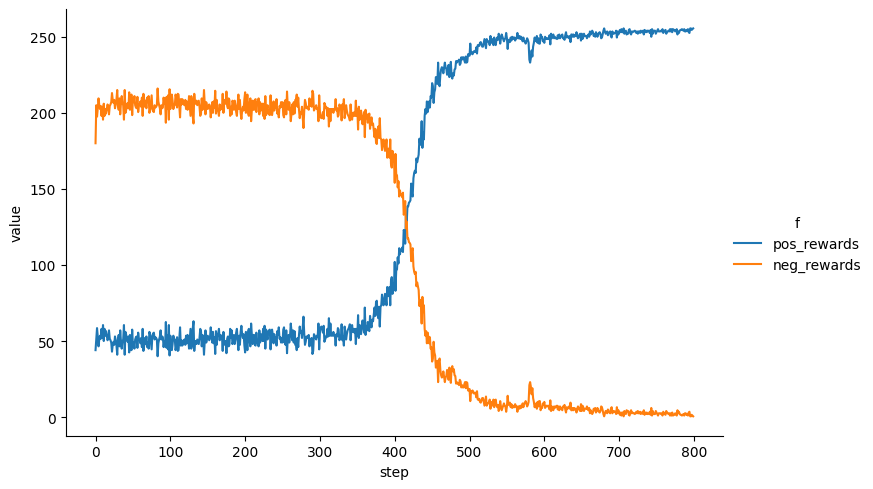

In [12]:
sns.relplot(
    data=df[df.f.isin(['pos_rewards', 'neg_rewards'])],
    x='step',
    y='value',
    kind='line',
    hue='f',
    errorbar=None,
    aspect=1.5,
)
plt.show()

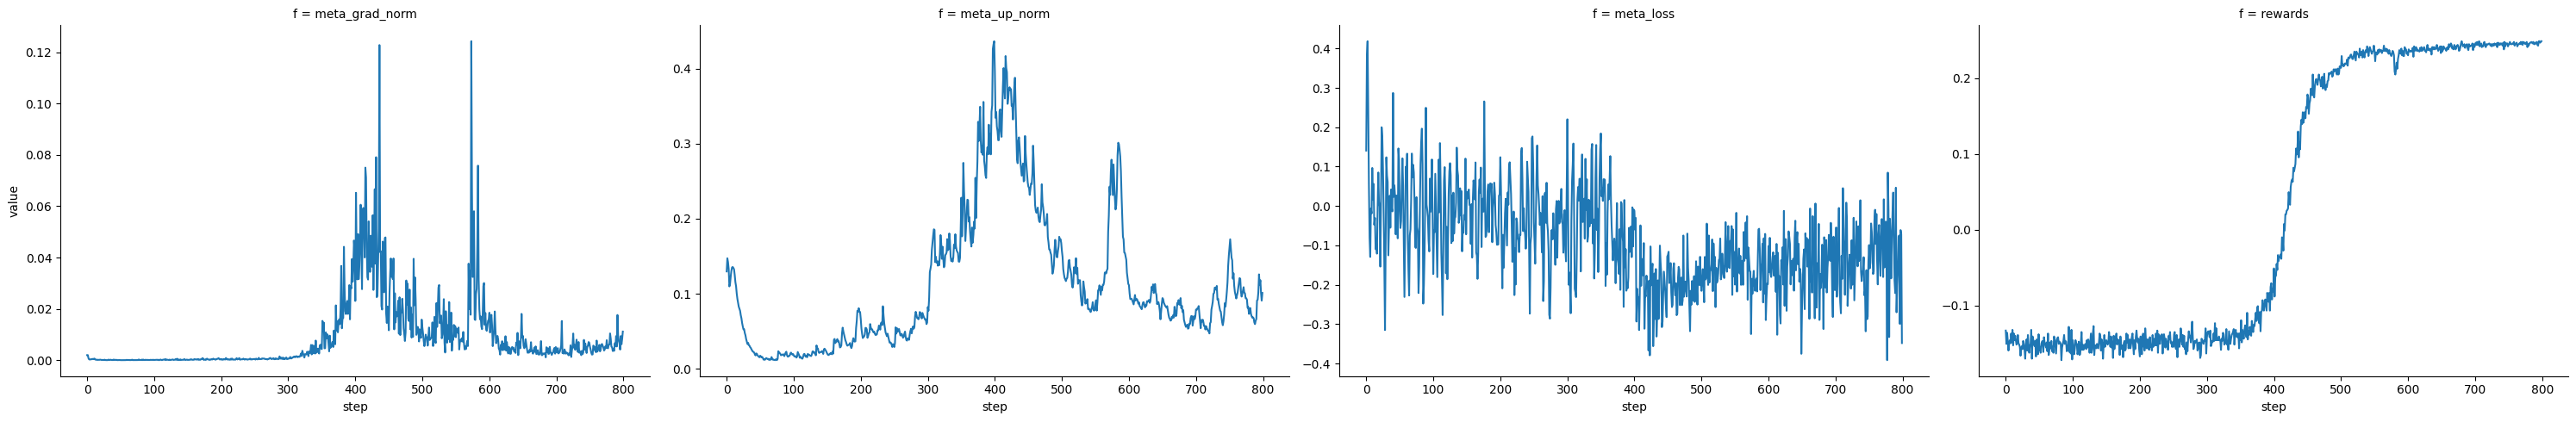

In [13]:
sns.relplot(
    data=df[
        df.f.isin(['meta_grad_norm', 'meta_loss', 'meta_up_norm', 'rewards'])
    ],
    x='step',
    y='value',
    kind='line',
    col='f',
    errorbar=None,
    aspect=1.5,
    facet_kws={'sharey': False, 'sharex': True},
)
plt.show()